## CFPB Complaints Analysis

In [1]:
# Importing Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
df_complaints = pd.read_csv('/Users/nikitaakenkre/Downloads/complaints_25Nov21.csv')
df_complaints

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


### Question 1

##### Our initial task should involve determining the number of customers who have lodged complaints following the bank's initial resolution.

In [3]:
# Set your X (predictor) and y (predicted) variables
selected_features = ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',
                     'Company response to consumer', 'Timely response?']
X = df_complaints[selected_features]
X.fillna('unknown', inplace = True)
le = LabelEncoder()
y = le.fit_transform(df_complaints['Consumer disputed?'])

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=selected_features)

# Split the data into a test and train set (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=123)

# Calculate the proportion of consumers who raised a dispute in the test set
proportion_disputed_test = sum(y_test) / len(y_test)
print("Proportion of consumers who raised a dispute in the test set: {:.2f}%".format(proportion_disputed_test * 100))

/var/folders/y_/nrd783r52pjc0n79mtxkyz7c0000gn/T/ipykernel_9187/496478244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna('unknown', inplace = True)


Proportion of consumers who raised a dispute in the test set: 21.59%


### Question 2

##### We have employed a random undersampling technique on the training set to assess the percentage of customers who have initiated disputes.

In [4]:
# Perform random undersampling
if proportion_disputed_test < 0.3:
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X_encoded, y)

# Check the proportion of disputed complaints in the training dataset after random undersampling
proportion_disputed_after_undersampling = (y_train == 1).mean()

print(f"The proportion of consumers who raised a dispute in the training dataset after random undersampling: {proportion_disputed_after_undersampling:.2%}")

The proportion of consumers who raised a dispute in the training dataset after random undersampling: 50.00%


### Question 3

##### Utilizing XGBoost, we will now evaluate the model's precision, recall, and accuracy while also generating a confusion matrix to gain insights into the true positive, true negative, false positive, and false negative predictions.

In [5]:
# Train a predictive model using XGBoost Classifier
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train, y_train)

# Evaluate the model on the test set and calculate recall
y_pred = model_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.53      0.66     32504
           1       0.28      0.65      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.73      0.56      0.60     41452



### Question 4

##### Our goal is to calculate the overall cost that the bank would bear without the predictive model. The following penalties apply to the bank in the event of these complaints:

##### 1. In the case of a filed complaint, the bank incurs a cost of $100 for all complaints.
##### 2. If the customer accepts the bank's resolution, the matter is considered resolved.
##### 3. If the customer rejects the bank's resolution, there is an additional cost of $500 that the bank must cover.

In [6]:
# Define a function to calculate the cost of dealing with a complaint
def calculate_complaint_cost(complaint_row):
    # Replace this with your logic to calculate the cost
    # Example: if a complaint is costly and you have a cost associated with it
    if complaint_row['Consumer disputed?'] == 'Yes':
        return 600  # Replace 100 with the actual cost
    else:
        return 100  # Replace 50 with the actual cost for other complaints

# Apply the function to each complaint in the test set
test_set = df_complaints.sample(frac=0.2, random_state=123)  # Assuming a 20% test set split
test_set['Complaint Cost'] = test_set.apply(calculate_complaint_cost, axis=1)

# Calculate the total cost
cost_without_model = test_set['Complaint Cost'].sum()

print(f"Estimated total cost without a model : ${cost_without_model:.2f}")

Estimated total cost without a model : $8619200.00


### Question 5

##### We are making predictions based on the aforementioned penalties associated with these complaints. In addition to this, there is another scenario:

##### Using the predictions, the bank can assess the probability of whether a customer will accept or reject a complaint resolution. If a complaint is more likely to be rejected, the bank can consider investing an additional $90 for further due diligence. This proactive step can help the bank avoid significant costs associated with rejections.

[[17353 15151]
 [ 3104  5844]]
Total cost to the banks of dealing with the complaints in the test set: $7586750


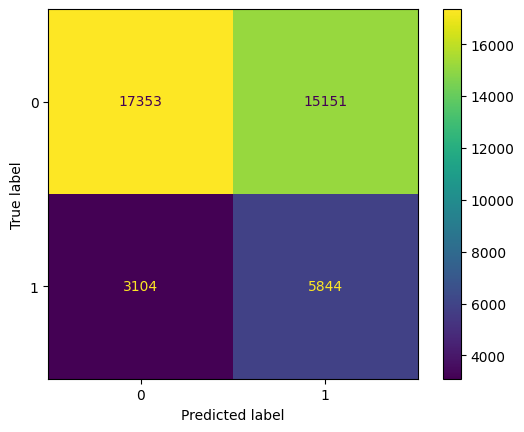

In [7]:
# Define cost structure
base_cost = 100  # Initial cost for every complaint
extra_diligence_cost = 90  # Cost for extra diligence
disputed_cost = 600  # Cost if a complaint is disputed

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate total cost
true_positives, false_positives, false_negatives, true_negatives  = confusion.ravel()

total_cost = (
    ((true_negatives + false_positives) * (base_cost + extra_diligence_cost)) +  # Non-disputed complaints
    (false_negatives * (disputed_cost)) +  # Predicted disputes with extra diligence
    (true_positives * base_cost)  # Predicted disputes without extra diligence
)

print(confusion)
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test)

print(f"Total cost to the banks of dealing with the complaints in the test set: ${total_cost}")

### Question 6 & 7

##### Now, we will attempt to determine the optimal threshold at which the bank incurs the lowest penalty. In this process, data points with predictions exceeding the threshold will be categorized as one class, while those falling below it will be categorized as the other class in binary classification tasks.

In [8]:
# Initialize variables to keep track of the best threshold and lowest cost
best_threshold = 0
lowest_cost = float('inf')

# Iterate through different threshold values
for threshold in np.linspace(0, 1, 101):  # Adjust the range and granularity as needed
    # Make predictions on the test set
    y_prob = model_xgb.predict_proba(X_test)
    # We drop the probabilities for class 0, and keep just the second column
    y_prob = y_prob[:,1]
    y_pred = (y_prob >= threshold).astype(int)  # Predict using the threshold

    # Calculate the confusion matrix
    confusion = confusion_matrix(y_test, y_pred)

    # Calculate total cost
    tn, fp, fn, tp = confusion.ravel()
    total_cost = ((tn*100) + ((tp+fp)*(100+90)) + (fn*600))

    # Check if this threshold results in a lower cost
    if total_cost < lowest_cost:
        lowest_cost = total_cost
        best_threshold = threshold

print(f"Best threshold for the lowest total cost: {best_threshold}")
print(f"Lowest total cost: ${lowest_cost}")

Best threshold for the lowest total cost: 0.46
Lowest total cost: $7491540
